<a href="https://colab.research.google.com/github/xssChauhan/Blog-Posts/blob/master/Towards_PyTorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 11.3 MB/s eta 0:00:00


# Static vs Dynamic Graphs


## Static Graph of Tensorflow < 2.0

In [2]:

# Importing tensorflow version 1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Initializing placeholder variables of
# the graph
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)

# Defining the operation
c = tf.multiply(a, b)

# Graph is created at this point

# Instantiating a tensorflow session
with tf.Session() as sess:

	# Computing the output of the graph by giving
	# respective input values
	out = sess.run([a,b,c], feed_dict={a: [15.0], b: [20.0]})[0][0]

	# Computing the output gradient of the output with
	# respect to the input 'a'
	derivative_out_a = sess.run(tf.gradients(c, a), feed_dict={
								a: [15.0], b: [20.0]})[0][0]

	# Computing the output gradient of the output with
	# respect to the input 'b'
	derivative_out_b = sess.run(tf.gradients(c, b), feed_dict={
								a: [15.0], b: [20.0]})[0][0]

	# Displaying the outputs
	print(f'c = {out}')
	print(f'Derivative of c with respect to a = {derivative_out_a}')
	print(f'Derivative of c with respect to b = {derivative_out_b}')


Instructions for updating:
non-resource variables are not supported in the long term


c = 15.0
Derivative of c with respect to a = 20.0
Derivative of c with respect to b = 15.0


## Pros
 - Optimized -> Incredibly Fast
 - Graph is defined once, and data flows through it

## Cons
 - You are an observer of data flowing through the graph
   `session.run(...)` -> Harder to debug
 - Restriction to dimensions of Data
 - Pythonic?

## Dynamic Graph of PyTorch < 2.0

In [3]:
# Importing torch
import torch

# Initializing input tensors
a = torch.tensor(15.0, requires_grad=True)
b = torch.tensor(20.0, requires_grad=True)

# Computing the output
def multiply(a,b):
  return a * b

c = multiply(a,b)
# Computing the gradients
c.backward()

# Collecting the output gradient of the
# output with respect to the input 'a'
derivative_out_a = a.grad

# Collecting the output gradient of the
# output with respect to the input 'b'
derivative_out_b = b.grad

# Displaying the outputs
print(f'c = {c}')
print(f'Derivative of c with respect to a = {derivative_out_a}')
print(f'Derivative of c with respect to b = {derivative_out_b}')


c = 300.0
Derivative of c with respect to a = 20.0
Derivative of c with respect to b = 15.0


## Pros:
- More freedom, and pythonic
- Easier to debug

## Cons:
- Graph is created on the fly as computations happen
- Graph is created each time the computation happens

In [4]:
# Graph will be created again
d = multiply(a,b)
# And Again
d = multiply(a,b)
# .
# .
# .
for _ in range(10):
  d = multiply(a,b)

# Dynamic Graph

In [5]:
a = torch.tensor(15.0, requires_grad=True)
b = torch.tensor(20.0, requires_grad=True)
v = a*b
print(v)

tensor(300., grad_fn=<MulBackward0>)


There would be no gradiets since we have not yet executed the backward graph

In [6]:

print(f"gradient of a {a.grad}, graident of b {b.grad}")

gradient of a None, graident of b None


Let's execute the backward graph

In [7]:
v.backward(retain_graph=True) # <-- Execute the backward graph now, graph comes into play only now
print(f"gradient of a {a.grad}, graident of b {b.grad}")

gradient of a 20.0, graident of b 15.0


In [8]:
print(v.grad)

None


<ipython-input-8-121b281ea4c9>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print(v.grad)


This is where we would have to stop with a static graph, but with a dynamic graph we can add more nodes to the graph by doing more operations

In [9]:
w = torch.log(v)
print(w)

tensor(5.7038, grad_fn=<LogBackward0>)


In [10]:
## And we can still calculate the gradient

w.backward()
print(f"gradient of a {a.grad}, graident of b {b.grad}")

gradient of a 20.066667556762695, graident of b 15.050000190734863


# PyTorch 2.0

Lets verify if we have the correct version

In [11]:
import torch
torch.__version__

'2.0.1+cu118'

## What does PyTorch see?
1. The intermediate representation which PyTorch uses for actual calculations.

In [12]:
import torch._dynamo
from torch.fx.passes.graph_drawer import FxGraphDrawer
from functorch.compile import make_boxed_func
from torch._functorch.aot_autograd import aot_module_simplified

def f(x):
    return torch.sin(x)**2 + torch.cos(x)**2

def inspect_backend(gm, sample_inputs):
    # Forward compiler capture
    def fw(gm, sample_inputs):
        gm.print_readable()
        g = FxGraphDrawer(gm, 'fn')
        with open("forward_aot.svg", "wb") as file:
            file.write(g.get_dot_graph().create_svg())
        return make_boxed_func(gm.forward)

    # Backward compiler capture
    def bw(gm, sample_inputs):
        gm.print_readable()
        g = FxGraphDrawer(gm, 'fn')
        with open("backward_aot.svg", "wb") as file:
            file.write(g.get_dot_graph().create_svg())
        return make_boxed_func(gm.forward)

    # Call AOTAutograd
    gm_forward = aot_module_simplified(gm,sample_inputs,
                                       fw_compiler=fw,
                                       bw_compiler=bw)

    return gm_forward

device="cpu"
torch.manual_seed(0)
x = torch.rand(1000, requires_grad=True).to(device)
y = torch.ones_like(x)

torch._dynamo.reset()
compiled_f = torch.compile(f, backend=inspect_backend)
out = torch.nn.functional.mse_loss(compiled_f(x), y).backward()

class GraphModule(torch.nn.Module):
    def forward(self, primals_1: f32[1000]):
        # File: <ipython-input-12-f1f531651a55>:7, code: return torch.sin(x)**2 + torch.cos(x)**2
        sin: f32[1000] = torch.ops.aten.sin.default(primals_1)
        pow_1: f32[1000] = torch.ops.aten.pow.Tensor_Scalar(sin, 2)
        cos: f32[1000] = torch.ops.aten.cos.default(primals_1)
        pow_2: f32[1000] = torch.ops.aten.pow.Tensor_Scalar(cos, 2)
        add: f32[1000] = torch.ops.aten.add.Tensor(pow_1, pow_2);  pow_1 = pow_2 = None
        return [add, sin, cos, primals_1]
        
class GraphModule(torch.nn.Module):
    def forward(self, sin: f32[1000], cos: f32[1000], primals_1: f32[1000], tangents_1: f32[1000]):
        # File: <ipython-input-12-f1f531651a55>:7, code: return torch.sin(x)**2 + torch.cos(x)**2
        pow_3: f32[1000] = torch.ops.aten.pow.Tensor_Scalar(cos, 1.0);  cos = None
        mul: f32[1000] = torch.ops.aten.mul.Scalar(pow_3, 2.0);  pow_3 = None
        mul_1: f32[1000] 

2. The forward and backward computation graphs

- Forward Graph

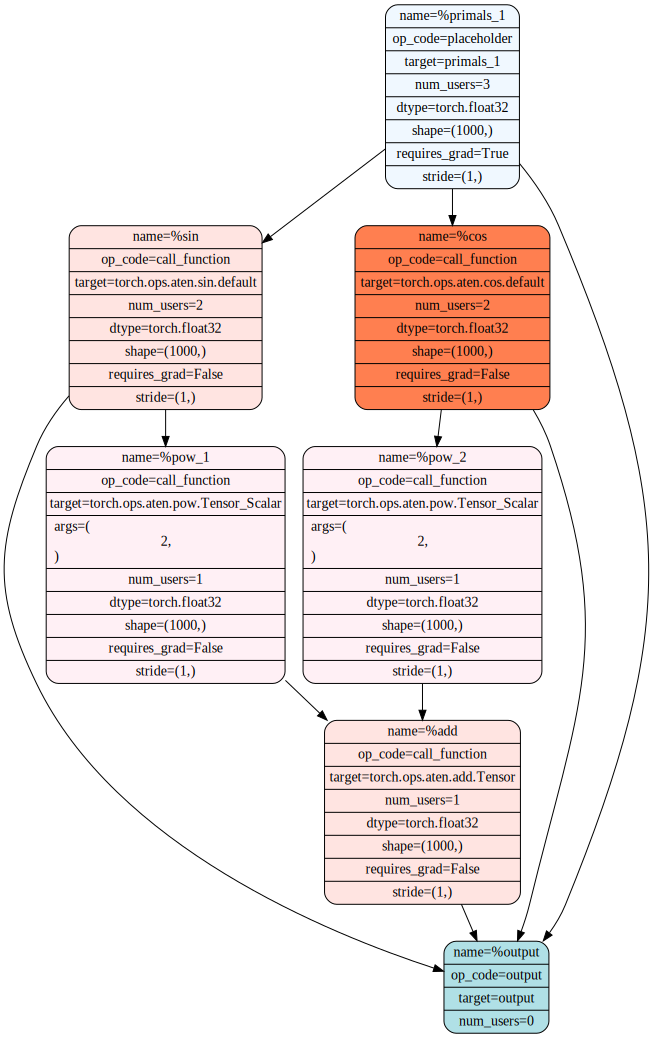

In [13]:
from IPython.display import SVG

SVG("forward_aot.svg")

- Backward Graph

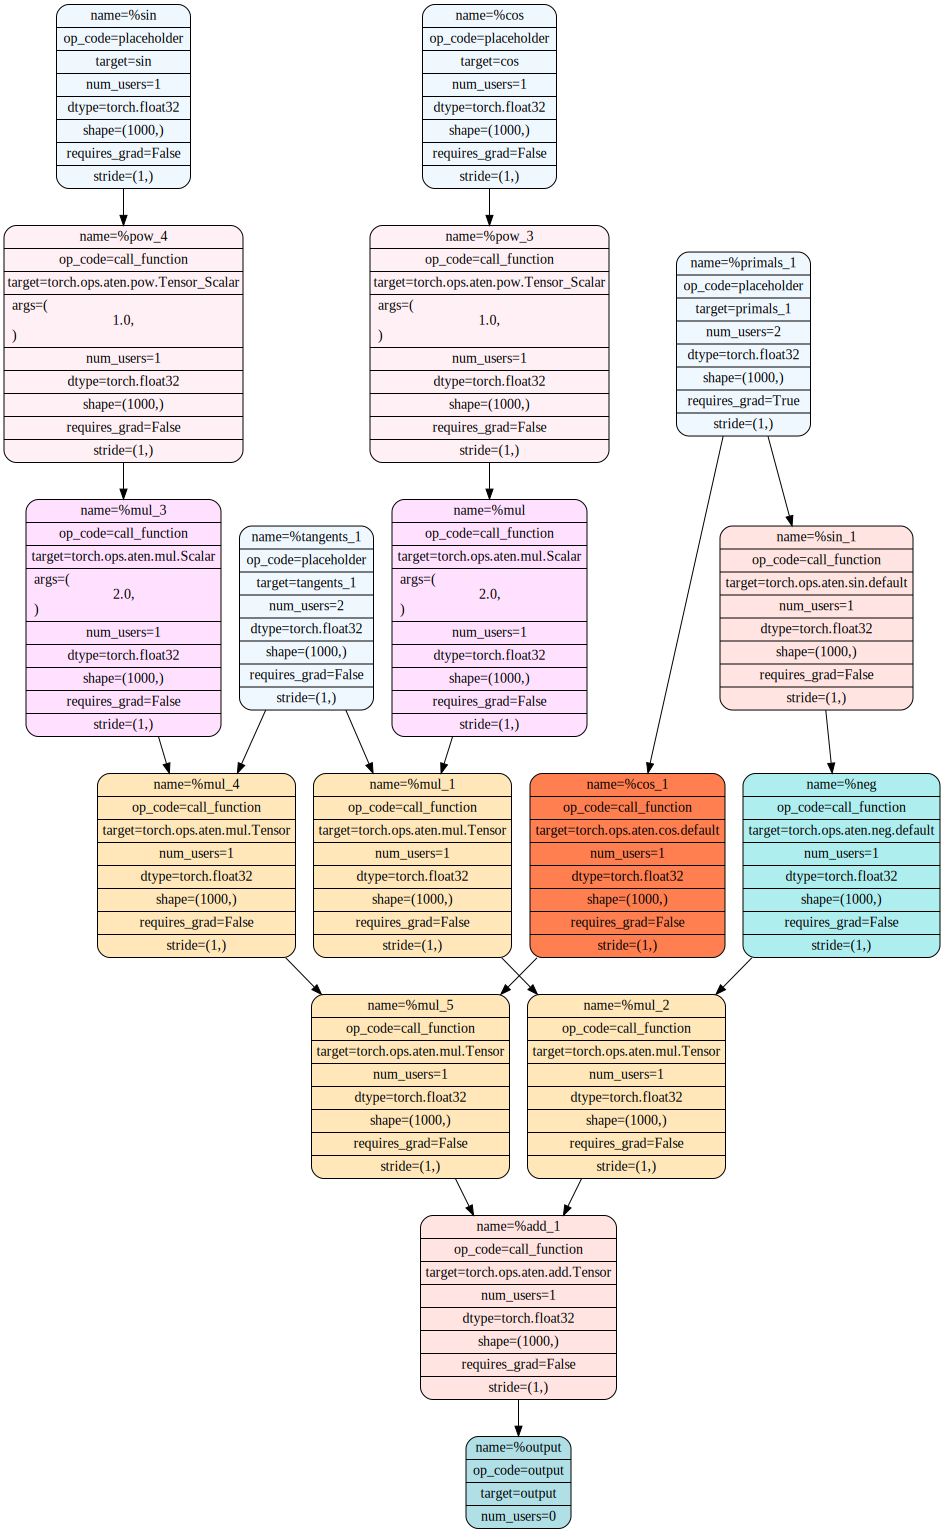

In [14]:
SVG("backward_aot.svg")

- Each operation gets a separate node, and kernel
- For each node, a separate GPU kernel is launched, and variables are moved across memory and compute,

## Operator Fusion in Action

In [15]:
def f(x):
    return torch.sin(x)**2 + torch.cos(x)**2

torch._dynamo.reset()
compiled_f = torch.compile(f, backend='inductor',
                              options={'trace.enabled':True,
                                       'trace.graph_diagram':True})

# device = 'cpu'
device = 'cuda'

torch.manual_seed(0)
x = torch.rand(1000, requires_grad=True).to(device)
y = torch.ones_like(x)

out = torch.nn.functional.mse_loss(compiled_f(x),y).backward()

Writing FX graph to file: /content/torch_compile_debug/run_2023_07_04_11_14_32_897828-pid_4035/aot_torchinductor/model__1_forward_4.0/graph_diagram.svg


[2023-07-04 11:14:34,416] torch._inductor.debug: [WARNING] model__1_forward_4 debug trace: /tmp/torchinductor_root/s3/cs3eewb33m2z3xznwwdypptepzlks6c5bvmuclf5x7z75mffxq7m.debug


Writing FX graph to file: /content/torch_compile_debug/run_2023_07_04_11_14_32_897828-pid_4035/aot_torchinductor/model__1_backward_5.1/graph_diagram.svg


[2023-07-04 11:14:35,429] torch._inductor.debug: [WARNING] model__1_backward_5 debug trace: /tmp/torchinductor_root/ik/cik3c37t425xmww3gfjrtnmbuct47syicysbhrjttdfu3bfgpdmy.debug


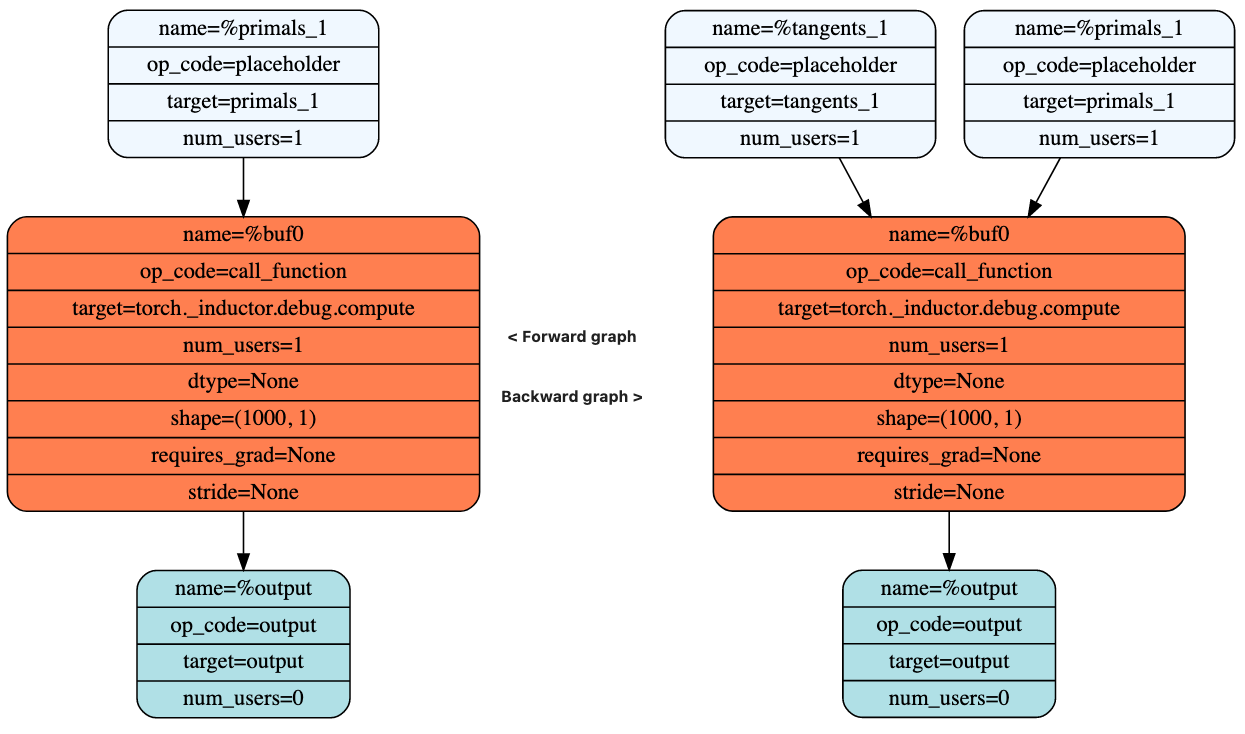

All the operations have now been combined into one kernel and operation

## Let's train `BeRT` using PyTorch Eager Mode

In [2]:
! pip install transformers[torch] datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.0 MB/s eta 0:00:00


In [3]:


from datasets import load_dataset

dataset = load_dataset("yelp_review_full")
dataset["train"][100]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [6]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [7]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [8]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [9]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.175273,0.459000
2,No log,1.000204,0.587000
3,No log,1.019067,0.588000


TrainOutput(global_step=375, training_loss=0.9769386393229167, metrics={'train_runtime': 105.7262, 'train_samples_per_second': 28.375, 'train_steps_per_second': 3.547, 'total_flos': 789354427392000.0, 'train_loss': 0.9769386393229167, 'epoch': 3.0})

## Let's `torch.compile` the model


In [10]:
import torch

from transformers import BertForSequenceClassification

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")


tokenized_datasets = dataset.map(tokenize_function, batched=True)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5).to("cuda:0")
# model = torch.compile(model)
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    torch_compile=True # <===== huggingface will take care of the compilation for us
    )
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [11]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[2023-07-04 11:45:29,507] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.149023,0.468000
2,No log,1.022488,0.572000
3,No log,1.021325,0.573000


TrainOutput(global_step=375, training_loss=1.0395946451822917, metrics={'train_runtime': 83.3899, 'train_samples_per_second': 35.976, 'train_steps_per_second': 4.497, 'total_flos': 789354427392000.0, 'train_loss': 1.0395946451822917, 'epoch': 3.0})